In [1]:
import time

import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn

from xopt import VOCS
from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

In [2]:
output_dir = "small_nn/"

## Load Existing Model

In [3]:
model_path = "lcls_cu_injector_nn_model/"

# # load nn_to_cal transformers
# reg = "low"  # "low" or "high"
# input_nn_to_cal = torch.load(f"calibration/input_nn_to_cal_{reg}_reg.pt")
# output_nn_to_cal = torch.load(f"calibration/output_nn_to_cal_{reg}_reg.pt")

# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_path + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_path + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_path + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_path + "model/output_pv_to_sim.pt")

# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(open(model_path + "model/pv_variables.yml"))
# input_variables, output_variables = variables_from_yaml(open(f"calibration/pv_variables_{reg}_reg.yml"))

# replace keys in input variables
# input_variables = {name.replace("BACT", "BCTRL"): ele for name, ele in input_variables.items()}

# create LUME-model
lume_model = PyTorchModel(
    model_file=model_path + "model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[output_sim_to_nn, output_pv_to_sim],
    # input_transformers=[input_pv_to_sim, input_sim_to_nn, input_nn_to_cal],
    # output_transformers=[output_nn_to_cal, output_sim_to_nn, output_pv_to_sim],
)

# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=lume_model.features,
    output_order=lume_model.outputs,
)

## Generate Training Data

In [4]:
vocs = VOCS(variables = {k: v.value_range for k, v in input_variables.items()})

# create local ranges around reference point
vars = {}
ratio = 0.1
for k, v in input_variables.items():
    v_range = v.value_range[1] - v.value_range[0]
    v_min = max(v.value_range[0], v.default - ratio * v_range)
    v_max = min(v.value_range[1], v.default + ratio * v_range)
    vars[k] = [v_min, v_max]
vocs_loc = VOCS(variables=vars)

In [5]:
%%time
n_samples = 500_000
filename_x = "x_n={:d}k.pt".format(int(2 * n_samples / 1e3))
filename_x_raw = "x_raw_n={:d}k.pt".format(int(2 * n_samples / 1e3))
filename_y = "y_n={:d}k.pt".format(int(2 * n_samples / 1e3))

try:
    x = torch.load(output_dir + filename_x)
    x_raw = torch.load(output_dir + filename_x_raw)
    y = torch.load(output_dir + filename_y)

except FileNotFoundError:
    
    x_full_raw = torch.from_numpy(pd.DataFrame(vocs.random_inputs(n_samples)).to_numpy())
    x_full = lume_model._transform_inputs(x_full_raw)
    with torch.no_grad():
        y_full = lume_model.model(x_full)
    
    x_loc_raw = torch.from_numpy(pd.DataFrame(vocs_loc.random_inputs(n_samples)).to_numpy())
    x_loc = lume_model._transform_inputs(x_loc_raw)
    with torch.no_grad():
        y_loc = lume_model.model(x_loc)

    x_raw = torch.cat([x_full_raw, x_loc_raw])
    x = torch.cat([x_full, x_loc])
    y = torch.cat([y_full, y_loc])

    torch.save(x, output_dir + filename_x)
    torch.save(x_raw, output_dir + filename_x_raw)
    torch.save(y, output_dir + filename_y)

CPU times: user 1.03 ms, sys: 49.7 ms, total: 50.8 ms
Wall time: 71.9 ms


## Create Model

In [6]:
def create_model(version: int = 0):
    if version == 0:
        model = nn.Sequential(
            nn.Linear(16, 100),
            nn.ELU(),
            nn.Linear(100, 200),
            nn.ELU(),
            nn.Dropout(p=0.05),
            nn.Linear(200, 200),
            nn.ELU(),
            nn.Dropout(p=0.05),
            nn.Linear(200, 100),
            nn.ELU(),
            nn.Dropout(p=0.05),
            nn.Linear(100, 100),
            nn.ELU(),
            nn.Linear(100, 5)
        )
    elif version == 1:
        model = nn.Sequential(
            nn.Linear(16, 32),
            nn.ELU(),
            nn.Linear(32, 64),
            nn.ELU(),
            nn.Dropout(p=0.05),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Dropout(p=0.05),
            nn.Linear(64, 32),
            nn.ELU(),
            nn.Dropout(p=0.05),
            nn.Linear(32, 32),
            nn.ELU(),
            nn.Linear(32, 5)
        )
    elif version == 2:
        model = nn.Sequential(
                nn.Linear(16, 32),
                nn.ReLU(),
                nn.Linear(32, 64),
                nn.ReLU(),
                nn.Dropout(p=0.05),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Dropout(p=0.05),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Dropout(p=0.05),
                nn.Linear(32, 32),
                nn.ReLU(),
                nn.Linear(32, 5)
            )
    elif version == 3:
        model = nn.Sequential(
                nn.Linear(16, 32),
                nn.Sigmoid(),
                nn.Linear(32, 64),
                nn.Sigmoid(),
                nn.Dropout(p=0.05),
                nn.Linear(64, 64),
                nn.Sigmoid(),
                nn.Dropout(p=0.05),
                nn.Linear(64, 32),
                nn.Sigmoid(),
                nn.Dropout(p=0.05),
                nn.Linear(32, 32),
                nn.Sigmoid(),
                nn.Linear(32, 5)
            )
    else:
        raise ValueError(f"Unknown model version {version}.")
    return model.double()

In [7]:
model_version = 0
model = create_model(model_version)

## Train Model

In [8]:
# define data set
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x, self.y, = x, y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        return x, y

In [9]:
# define train/test dataloaders
batch_size = 256
train_frac = 0.8

idx = torch.randperm(x.shape[0])
x, y = x[idx].double(), y[idx].double()
idx_split = int(train_frac * x.shape[0])
x_train, y_train = x[:idx_split], y[:idx_split]
x_test, y_test = x[idx_split:], y[idx_split:]

trainset = Dataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                                          num_workers=0, pin_memory=True)
testset = Dataset(x_test, y_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=y_test.shape[0], shuffle=True, 
                                         num_workers=0, pin_memory=True)

In [10]:
# training configuration
lr = 3e-5
reg = 0.0
n_epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
criterion = torch.nn.MSELoss()
# criterion = torch.nn.L1Loss()

In [11]:
# define filename
if criterion.__class__.__name__ == "MSELoss":
    loss_name = "mse"
elif criterion.__class__.__name__ == "L1Loss":
    loss_name = "mae"
else:
    raise ValueError("Unknown loss function!")

filename = "v{:d}_{}_lr={:.0e}_reg={:.0e}_n={:d}_bs={:d}".format(model_version, loss_name, lr, reg, n_epochs, batch_size)

In [12]:
# train model
train_losses, test_losses = [], []
print("{:8s} {:>12s} {:>12s} {:>12s}".format("EPOCH", "TRAIN_LOSS", "TEST_LOSS", "ETA"))
t0 = time.time()
best_loss = torch.inf
for epoch in range(n_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        optimizer.zero_grad()
        model.train()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if i == 0:
            model.eval()
            inputs_test, targets_test = next(iter(testloader))
            outputs_test = model(inputs_test)
            test_loss = criterion(outputs_test, targets_test)

            # store losses
            train_losses.append(loss.item())
            test_losses.append(test_loss.item())

            # print info
            if epoch % (n_epochs // 10) == 0:
                t_avg = (time.time() - t0) / (epoch + 1)
                t_r = (n_epochs - epoch - 1) * t_avg / 60  # in minutes
                if t_r <= 1.0:
                    t_info = "{:.2f} sec".format(60 * t_r)
                else:
                    t_info = "{:.2f} min".format(t_r)
                info = "{:<8d} {:12.5f} {:12.5f} {:>12s}".format(epoch, loss, test_loss, t_info)
                if test_loss < best_loss:
                    info = "\033[0;32m" + info + '\x1b[0m'                
                print(info)
            
            # store best loss/model
            if test_loss < best_loss:
                best_loss = test_loss
                if i == 0:
                    torch.save(model, output_dir + filename + "_model_best.pt")

t_total = time.time() - t0
t_r = t_total / 60  # in minutes
if t_r <= 1.0:
    t_info = "{:.2f} sec".format(60 * t_r)
else:
    t_info = "{:.2f} min".format(t_r)                
print("Total runtime: {}".format(t_info))

EPOCH      TRAIN_LOSS    TEST_LOSS          ETA
0             0.08925      0.09193    11.62 min
50            0.00129      0.00055   133.83 min
100           0.00107      0.00035   119.49 min
150           0.00068      0.00029   104.40 min
200           0.00083      0.00027    89.29 min
250           0.00068      0.00024    74.47 min
300           0.00070      0.00024    59.41 min
350           0.00056      0.00023    44.62 min
400           0.00062      0.00023    29.70 min
450           0.00059      0.00024    14.73 min
Total runtime: 150.66 min


In [13]:
# save final model and losses to file
torch.save(model, output_dir + filename + "_model_final.pt")
torch.save(torch.tensor([train_losses, test_losses]), output_dir + filename + "_losses.pt")

## Analyze Training Results

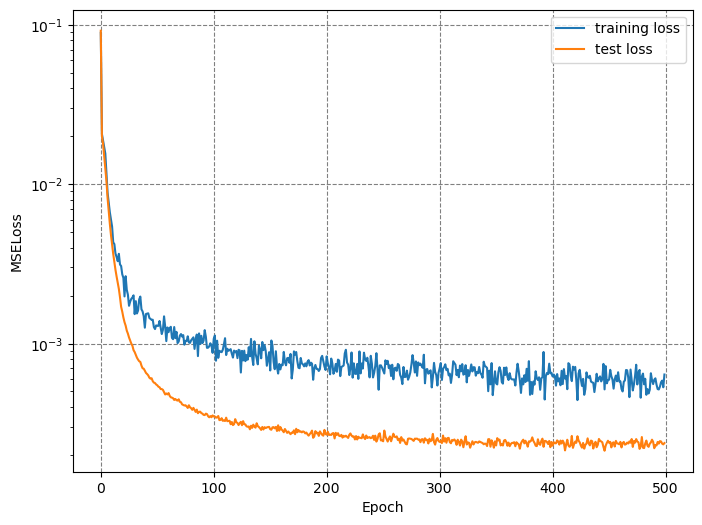

In [14]:
# plot training process
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.set_xlabel("Epoch")
ax.plot(train_losses, c="C0", label="training loss")
ax.plot(test_losses, c="C1", label="test loss")
ax.set_ylabel(criterion.__class__.__name__)
ax.legend(loc="upper right")
ax.set_axisbelow(True)
ax.set_yscale("log")
ax.grid(color="gray", linestyle="dashed")
fig.savefig(output_dir + filename + "_losses.png")

In [15]:
# create LUME-model
small_lume_model = PyTorchModel(
    model_file=output_dir + filename + "_model_best.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[output_sim_to_nn, output_pv_to_sim],
)

# wrap in LUMEModule
small_lume_module = LUMEModule(
    model=small_lume_model,
    feature_order=small_lume_model.features,
    output_order=small_lume_model.outputs,
)

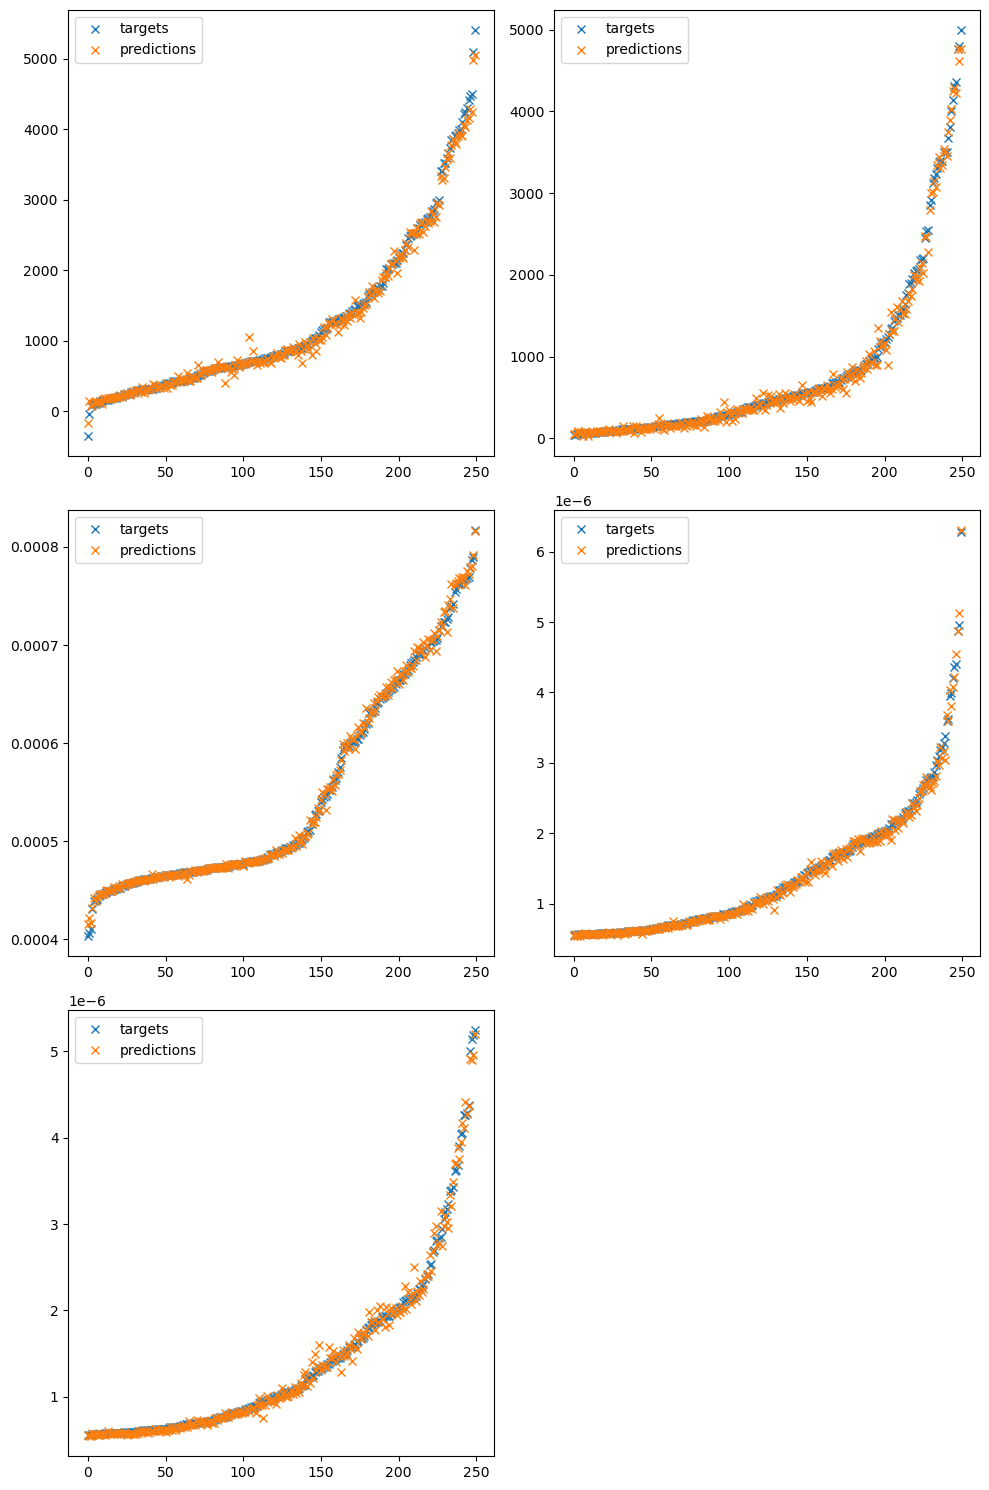

In [16]:
# compare exemplary predictions
idx = torch.randint(low=0, high=x_raw.shape[0], size=(250,))
with torch.no_grad():
    targets = lume_module(x_raw[idx])
    pred = small_lume_module(x_raw[idx])

nrows, ncols = 3, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 15))
for i in range(nrows * ncols):
    ax_i = ax[i // ncols, i % ncols]
    if i < targets.shape[1]:
        sort_idx = torch.argsort(targets[:, i])
        x_axis = torch.arange(targets.shape[0])
        ax_i.plot(x_axis, targets[sort_idx, i], "C0x", label="targets")
        ax_i.plot(x_axis, pred[sort_idx, i], "C1x", label="predictions")
        ax_i.legend()
ax[-1, -1].axis('off')
fig.tight_layout()
fig.savefig(output_dir + filename + "_predictions.png")

## Check 1D Scans

In [17]:
# define objective models
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2)

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)
small_objective_model = ObjectiveModel(small_lume_module)

In [18]:
# create reference point
x_default = torch.tensor([input_variables[key].default for key in input_variables.keys()], dtype=torch.double)

In [19]:
# define 1D scan sample function
def scan_x(name, n_samples=1000):
    idx = list(input_variables.keys()).index(name)
    v_lim = input_variables[name].value_range
    samples = x_default.repeat(n_samples, 1)
    samples[:, idx] = torch.linspace(v_lim[0], v_lim[1], n_samples, dtype=x_default.dtype)
    return samples

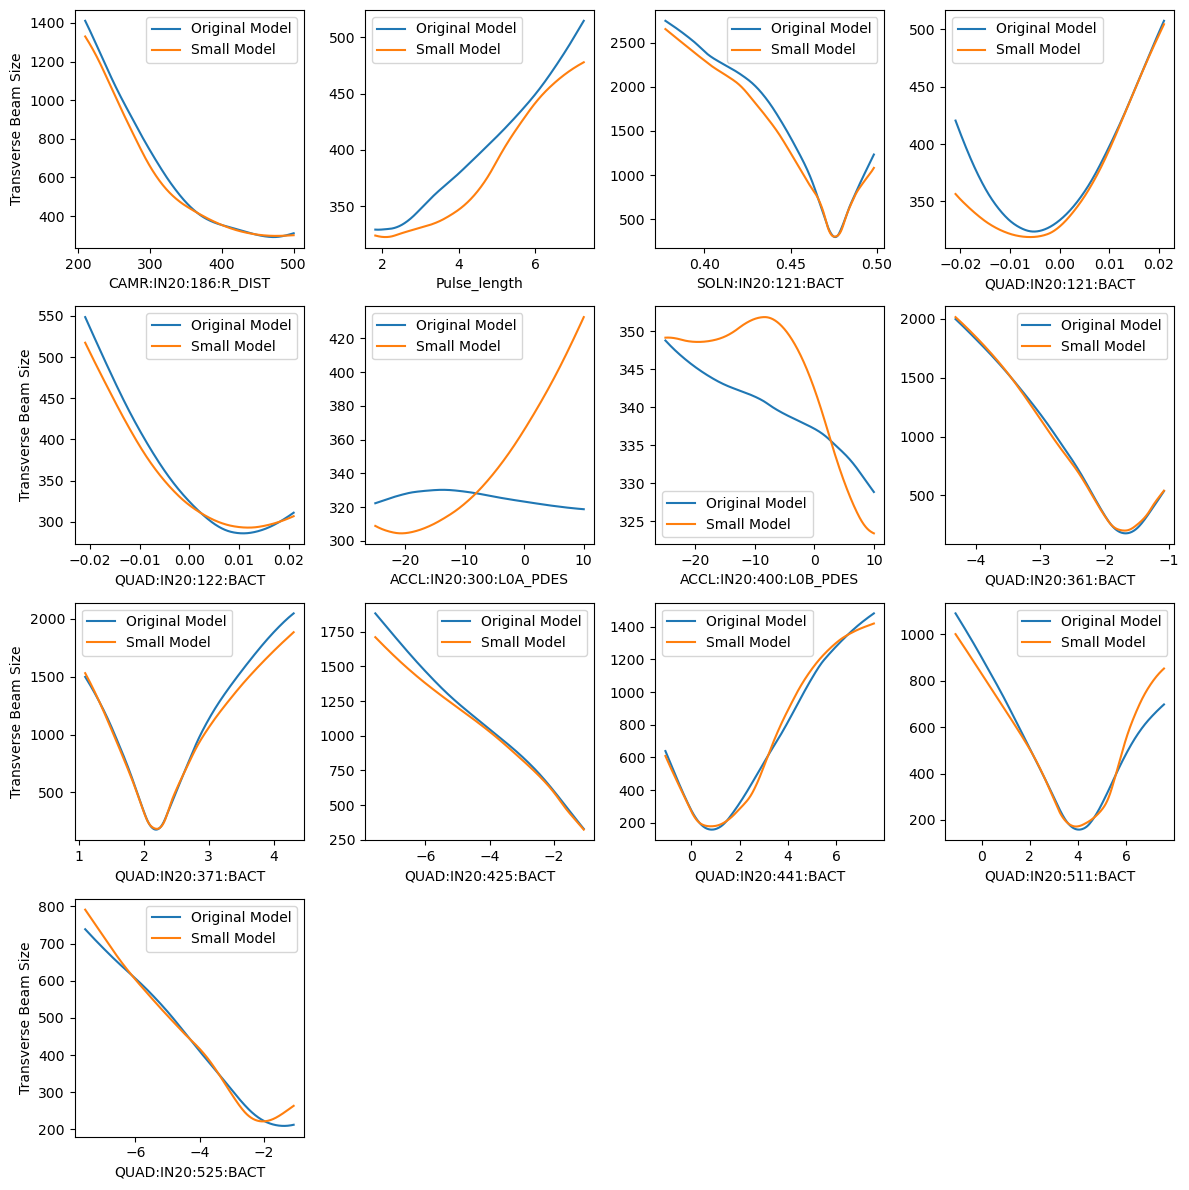

In [20]:
# compare 1D scans for original and calibrated model
nrows, ncols = 4, 4
figsize = (12, 12 * nrows / ncols)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharey=False, figsize=figsize)
n_skip = 0
for i in range(nrows * ncols):
    ax_i = ax[i // ncols, i % ncols]
    if i + n_skip >= len(input_variables.keys()):
        ax_i.axis('off')
    else:
        name = list(input_variables.keys())[i + n_skip]
        v_lim = input_variables[name].value_range

        while not v_lim[0] < v_lim[1]:
            n_skip += 1
            name = list(input_variables.keys())[i + n_skip]
            v_lim = input_variables[name].value_range

        # compute 1D scans
        x_scan = scan_x(name=name)
        y_scan = objective_model(x_scan).detach()
        y_scan_small = small_objective_model(x_scan).detach()

        # plot data
        idx = list(input_variables.keys()).index(name)
        ax_i.plot(x_scan[:, idx], y_scan, "C0", label="Original Model")
        ax_i.plot(x_scan[:, idx], y_scan_small, "C1", label="Small Model")
        ax_i.set_xlabel(name)
        ax_i.legend()
        if i % ncols == 0:
            ax_i.set_ylabel("Transverse Beam Size")
fig.tight_layout()
fig.savefig(output_dir + filename + "_1d_scan.png")